CHINA CRIME DATA ANALYSIS

In [53]:
%pip install geopandas sqlalchemy pg8000

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 774.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 2.1 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
# Import necessary libraries
import pg8000
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [40]:
# Fetch Data from Postrgres
conn = pg8000.connect(
    host="localhost", 
    database="sample",  
    user="postgres",  
    password="1234",  
    port="5433"
)
cursor = conn.cursor()
cursor.execute("SELECT * FROM crime_data")

rows = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
crime_data = pd.DataFrame(rows, columns=columns)

cursor.close()
conn.close()

In [41]:
crime_data.head()

,Crime_ID,Crime_Type,Location,Date,Time,Victim_Age,Suspect_Age,Weapon_Used,Latitude,Longitude
0,1001,Burglary,Shenzhen,2024-01-01,00:00,63,30,Unknown,27.490802,103.702659
1,1002,Fraud,Wuhan,2024-01-01,00:01,47,59,Unknown,39.014286,110.838019
2,1003,Burglary,Beijing,2024-01-01,00:02,57,20,Unknown,34.639879,117.458917
3,1004,Assault,Chongqing,2024-01-02,00:04,35,26,Knife,31.973170,114.644498
4,1005,Assault,Shenzhen,2024-01-02,00:05,68,29,Unknown,23.120373,116.131223


In [45]:
# 1. Fill in Missing Values (or remove rows)
print(crime_data.isnull().sum()) 

# Fill with a placeholder (like "Unknown" for categorical columns):
crime_data['Weapon_Used'].fillna('Unknown', inplace=True)

# Remove rows with missing values (if too many values are missing)
crime_data.dropna(inplace=True) 

# 2. Ensure Dates are in Proper Format
crime_data['Date'] = pd.to_datetime(crime_data['Date'])

# 3. Check for Correctly Labeled Categories
#    - Examine the unique values in categorical columns:
print(crime_data['Crime_Type'].unique())
print(crime_data['Location'].unique())
print(crime_data['Weapon_Used'].unique())

# Correct any misspellings or inconsistencies (e.g., "theft" vs. "Theft")
crime_data['Crime_Type'] = crime_data['Crime_Type'].str.capitalize() 

# Feature engineering: Extract hour of the day from 'Time'
crime_data['Hour'] = crime_data['Time'].str.split(':').str[0].astype(int)

# 4. Remove Duplicated Entries
crime_data.drop_duplicates(inplace=True)

Crime_ID       0
Crime_Type     0
Location       0
Date           0
Time           0
Victim_Age     0
Suspect_Age    0
Weapon_Used    0
Latitude       0
Longitude      0
Month          0
Hour           0
dtype: int64
['Burglary' 'Fraud' 'Assault' 'Theft' 'Vandalism']
['Shenzhen' 'Wuhan' 'Beijing' 'Chongqing' 'Guangzhou' 'Shanghai' 'Chengdu'
 "Xi'an"]
['Unknown' 'Knife' 'Gun' 'Bat']


/var/folders/72/pv5wnsts00schnl2k5rzbc7r0000gn/T/ipykernel_94700/2960113629.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  crime_data['Weapon_Used'].fillna('Unknown', inplace=True)


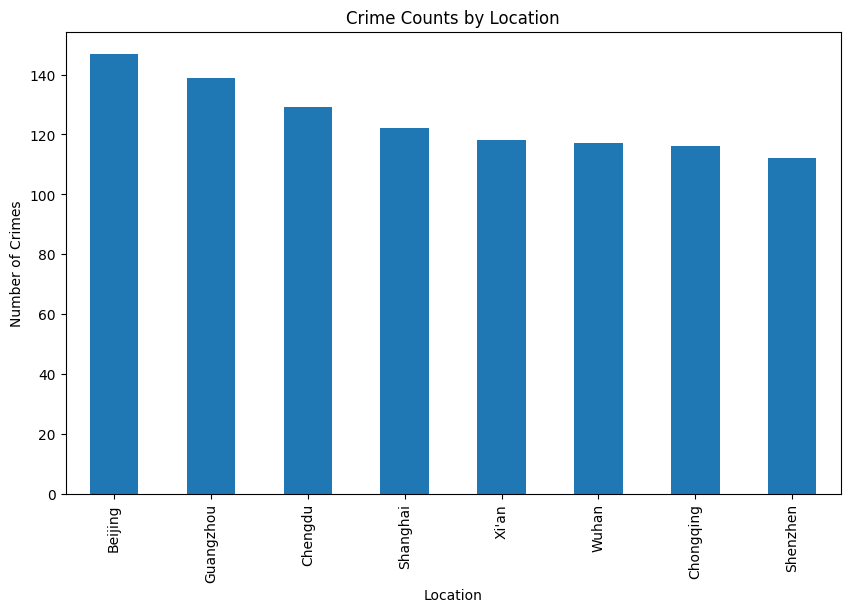

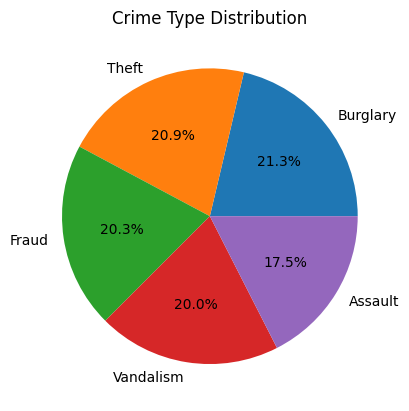

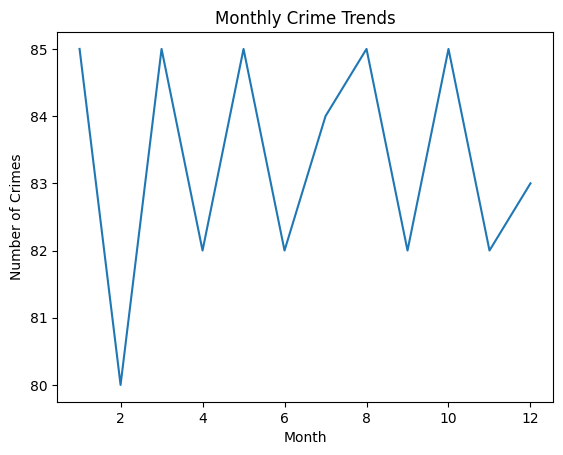

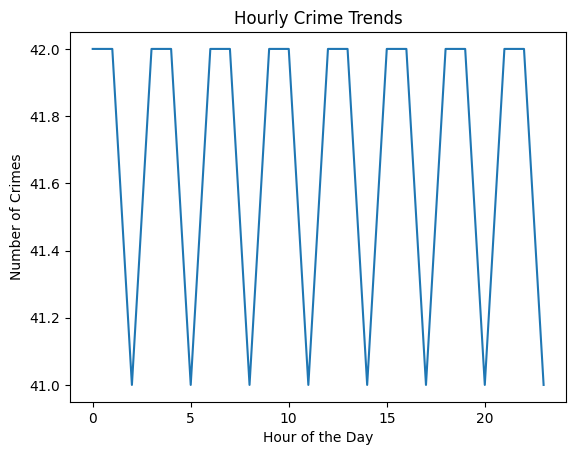

In [46]:
# Crime rates by location
crime_counts = crime_data['Location'].value_counts()
plt.figure(figsize=(10, 6))
crime_counts.plot(kind='bar')
plt.title('Crime Counts by Location')
plt.xlabel('Location')
plt.ylabel('Number of Crimes')
plt.show()

# Crime type distribution
crime_type_counts = crime_data['Crime_Type'].value_counts()
plt.pie(crime_type_counts, labels=crime_type_counts.index, autopct='%1.1f%%')
plt.title('Crime Type Distribution')
plt.show()

# Time trends
crime_data['Month'] = crime_data['Date'].dt.month
crime_data['Hour'] = crime_data['Time'].str.split(':').str[0].astype(int)

monthly_crime = crime_data['Month'].value_counts().sort_index()
plt.plot(monthly_crime.index, monthly_crime.values)
plt.title('Monthly Crime Trends')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.show()

hourly_crime = crime_data['Hour'].value_counts().sort_index()
plt.plot(hourly_crime.index, hourly_crime.values)
plt.title('Hourly Crime Trends')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.show()

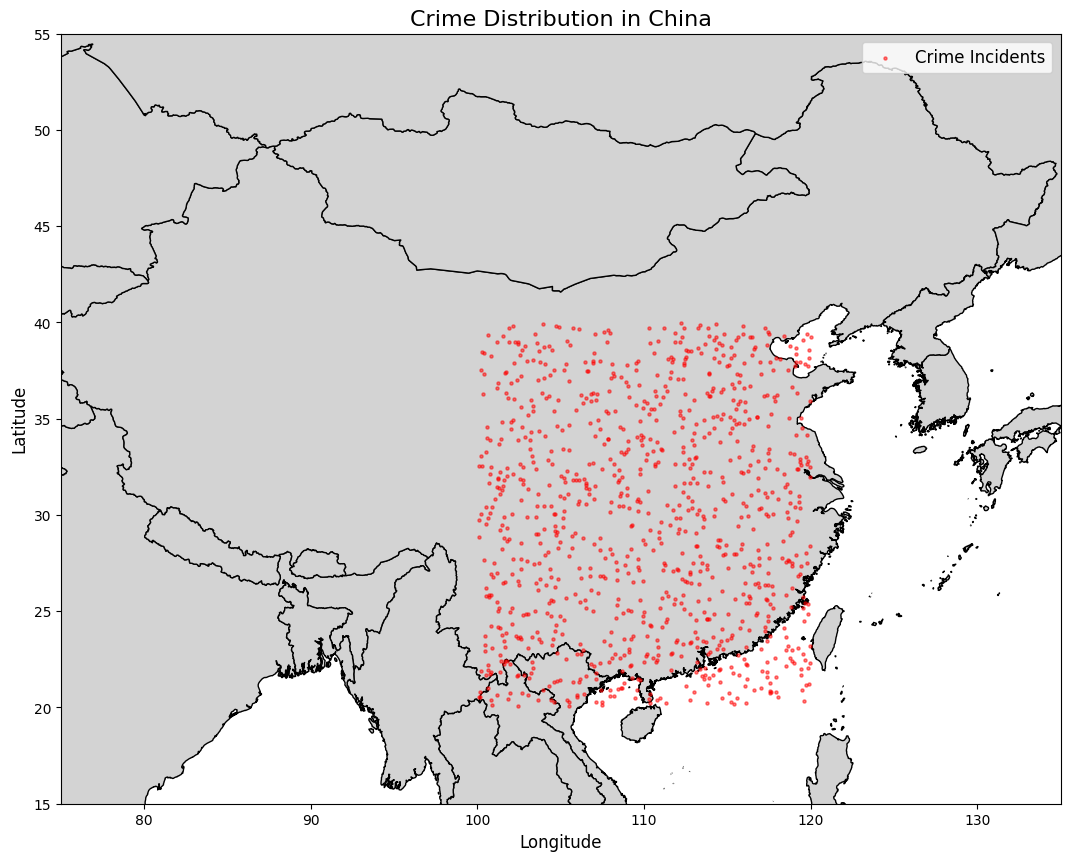

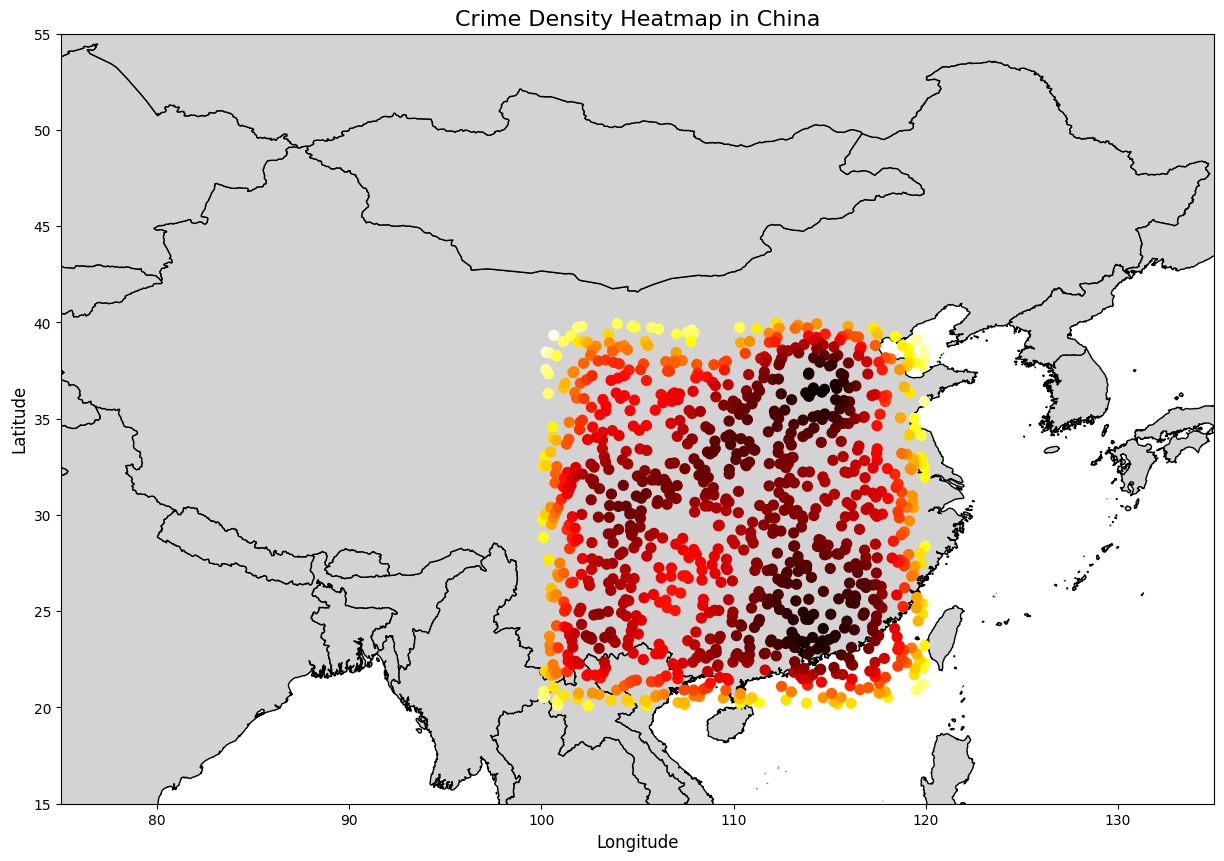

In [47]:
os.environ['SHAPE_RESTORE_SHX'] = 'YES'  # Set environment variable
china_map = gpd.read_file('/Users/ashiksharon/Documents/VIT/DE Lab/Crime Analysis/ne_10m_admin_0_countries_chn.shp')

# Set the CRS of china_map 
china_map.crs = 'EPSG:4490'

# Create a GeoDataFrame from your crime data
crime_gdf = gpd.GeoDataFrame(
    crime_data, geometry=gpd.points_from_xy(crime_data.Longitude, crime_data.Latitude),
    crs="EPSG:4490"  # Set initial CRS to WGS 84 
)

# Ensure CRS (Coordinate Reference Systems) match!
crime_gdf = crime_gdf.to_crs(china_map.crs)

# --- Plotting Crime Incidents on the Map ---
fig, ax = plt.subplots(1, figsize=(15, 10))
china_map.plot(ax=ax, color='lightgrey', edgecolor='black') 
crime_gdf.plot(ax=ax, markersize=5, color='red', alpha=0.5, label='Crime Incidents') 
plt.title('Crime Distribution in China', fontsize=16)

ax.set_xlim(75, 135)  # Longitude limits
ax.set_ylim(15, 55)   # Latitude limits

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(fontsize=12)
plt.show()

# --- Creating a Heatmap ---
# We'll use a Kernel Density Estimation (KDE) to create the heatmap
from scipy.stats import gaussian_kde

# Extract coordinates
x = crime_gdf.geometry.x
y = crime_gdf.geometry.y

# Calculate the KDE
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Sort the points by density
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

# Plot the heatmap
fig, ax = plt.subplots(1, figsize=(15, 10))
china_map.plot(ax=ax, color='lightgrey', edgecolor='black') 
ax.scatter(x, y, c=z, s=50, cmap='hot_r') # Use a reversed 'hot' colormap
plt.title('Crime Density Heatmap in China', fontsize=16)

ax.set_xlim(75, 135)  # Longitude limits
ax.set_ylim(15, 55)   # Latitude limits

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.show()

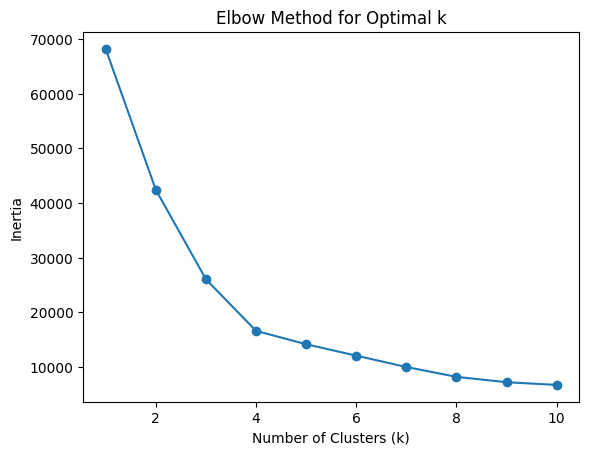

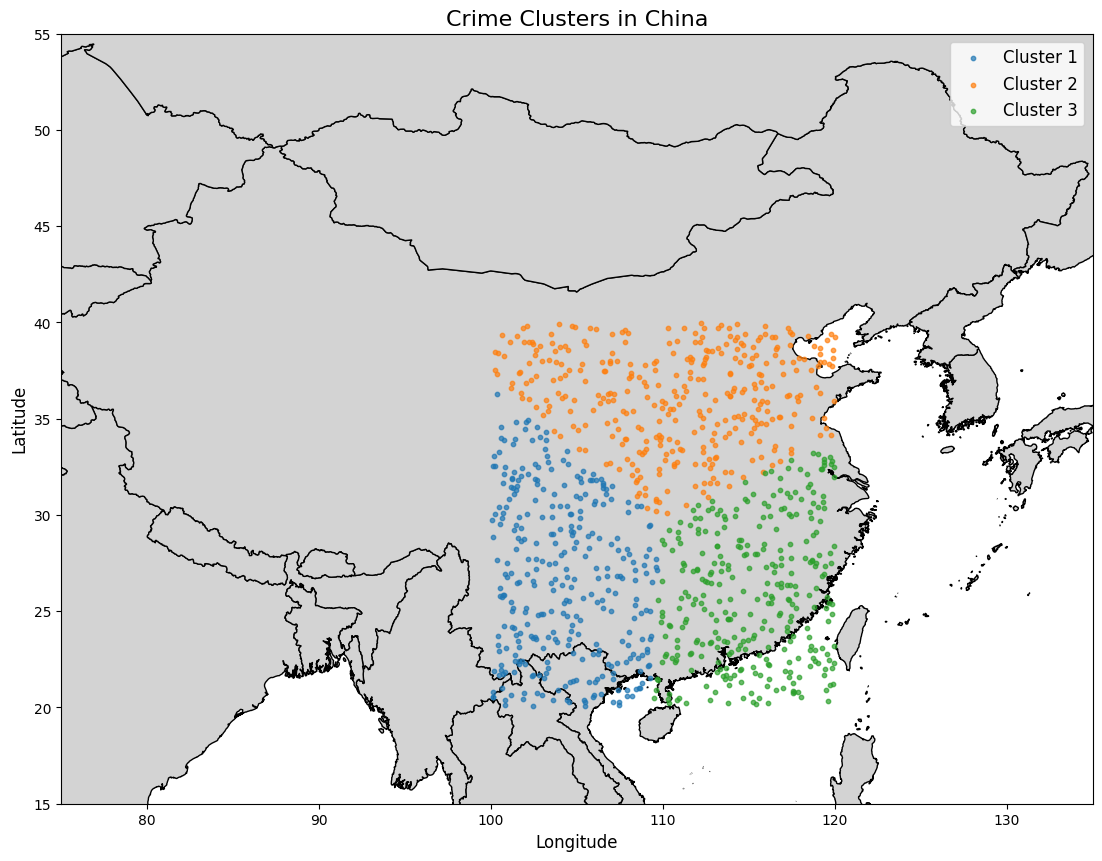

--- Crime Types in Cluster 1 ---
Crime_Type
Burglary     77
Fraud        66
Theft        62
Vandalism    60
Assault      57
Name: count, dtype: int64
--- Crime Types in Cluster 2 ---
Crime_Type
Vandalism    77
Theft        77
Burglary     70
Assault      67
Fraud        66
Name: count, dtype: int64
--- Crime Types in Cluster 3 ---
Crime_Type
Fraud        71
Theft        70
Burglary     66
Vandalism    63
Assault      51
Name: count, dtype: int64


In [48]:
# Prepare data for clustering (Latitude & Longitude)
X = crime_data[['Latitude', 'Longitude']]

# Determine the optimal number of clusters (using the elbow method)
inertia = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Choose the optimal k from the elbow plot
optimal_k = 3 # (Example, you need to choose based on the elbow plot)

# Apply KMeans with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)

# Add cluster labels to the GeoDataFrame
crime_gdf['Cluster'] = kmeans.labels_

# Visualize the clusters on the map
fig, ax = plt.subplots(1, figsize=(15, 10))
china_map.plot(ax=ax, color='lightgrey', edgecolor='black')
for i in range(optimal_k):
    crime_gdf[crime_gdf['Cluster'] == i].plot(
        ax=ax, markersize=10, label=f'Cluster {i+1}', alpha=0.7
    )

# Set plot limits to zoom into China 
ax.set_xlim(75, 135)  
ax.set_ylim(15, 55) 

plt.title('Crime Clusters in China', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend(fontsize=12)
plt.show()

# Explore crime types within each cluster
for i in range(optimal_k):
    print(f"--- Crime Types in Cluster {i+1} ---")
    print(crime_gdf[crime_gdf['Cluster'] == i]['Crime_Type'].value_counts()) 

Time Series Model (ARIMA Model) to predict future crime trends

In [49]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Aggregate crime counts by day
crime_ts = crime_data.groupby('Date')['Crime_ID'].count() 

# Split data into training and testing sets
train_data = crime_ts[:-30] # Use all but the last 30 days for training
test_data = crime_ts[-30:]   # Use the last 30 days for testing

# Determine ARIMA parameters (p, d, q) 
p, d, q = 5, 1, 0  

# Fit the ARIMA model to the training data
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.predict(start=len(train_data), end=len(crime_ts)-1)

# Evaluate the model (e.g., using RMSE or MAE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print(f"RMSE: {rmse}")

# # Plot actual vs. predicted values
# plt.plot(test_data, label='Actual')
# plt.plot(predictions, label='Predictions')
# plt.title('ARIMA Crime Prediction')
# plt.xlabel('Date')
# plt.ylabel('Crime Count')
# plt.legend()
# plt.show()

RMSE: 0.4386466597117866


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Crime_Type  Weapon_Used
Assault     Unknown        0.417143
            Knife          0.251429
            Bat            0.177143
            Gun            0.154286
Burglary    Unknown        0.413146
            Knife          0.244131
            Gun            0.173709
            Bat            0.169014
Fraud       Unknown        0.423645
            Bat            0.211823
            Knife          0.211823
            Gun            0.152709
Theft       Unknown        0.392344
            Bat            0.229665
            Knife          0.210526
            Gun            0.167464
Vandalism   Unknown        0.400000
            Knife          0.245000
            Gun            0.180000
            Bat            0.175000
Name: proportion, dtype: float64


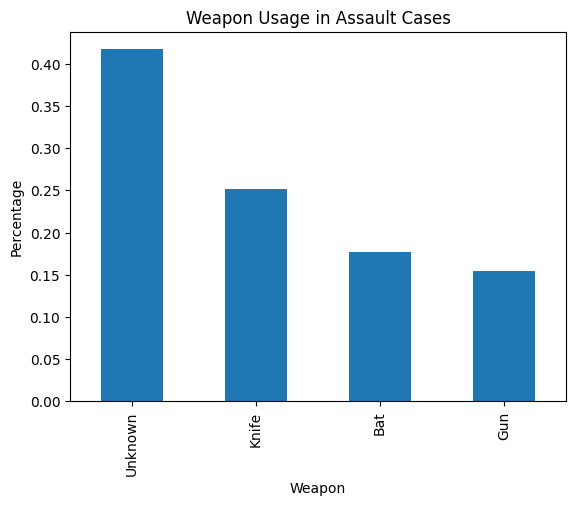

In [77]:
# Group by crime type and get the most common weapons used
weapon_usage = crime_data.groupby('Crime_Type')['Weapon_Used'].value_counts(normalize=True)
print(weapon_usage)

# Visualize the weapon usage (example)
weapon_usage['Assault'].plot(kind='bar')
plt.title('Weapon Usage in Assault Cases')
plt.xlabel('Weapon')
plt.ylabel('Percentage')
plt.show()

In [82]:
# Select features and target variable
features = ['Latitude', 'Longitude', 'Victim_Age', 'Suspect_Age']
target = 'Crime_Type'

In [87]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    crime_data[features], crime_data[target], test_size=0.2, random_state=42
)

# Create a Random Forest classifier
model = RandomForestClassifier(random_state=32)

In [88]:
# Train the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=32)

In [89]:
# Make predictions on the test data
y_pred = model.predict(X_test)

In [90]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.25


In [91]:
# Print a classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Assault       0.24      0.22      0.23        37
    Burglary       0.21      0.22      0.21        41
       Fraud       0.29      0.23      0.26        43
       Theft       0.29      0.33      0.31        45
   Vandalism       0.22      0.24      0.23        34

    accuracy                           0.25       200
   macro avg       0.25      0.25      0.25       200
weighted avg       0.25      0.25      0.25       200

